In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

# Load the RBI repo rate data
rbi_repo = pd.read_csv('rbi_repo.csv')
print("RBI Repo Rate data:")
print("Column names:", rbi_repo.columns.tolist())
print(rbi_repo.head())
print(f"\nRBI Repo data shape: {rbi_repo.shape}")

# Load the BBG data
df = pd.read_csv('bbg_data.csv')
print("\n" + "="*50)
print("BBG data:")
print("Column names:", df.columns.tolist())
print(df.head())
print(f"\nBBG data shape: {df.shape}")

RBI Repo Rate data:
Column names: ['Date', 'india_ir']
         Date  india_ir
0  11/24/2025      5.59
1  11/21/2025      5.59
2  11/20/2025      5.48
3  11/19/2025      5.44
4  11/18/2025      5.44

RBI Repo data shape: (55, 2)

BBG data:
Column names: ['Unnamed: 0', 'usdinr', 'india_cpi', 'india_unemployment', 'us_unemployment', 'us_cpi', 'us_ir']
            Unnamed: 0   usdinr  india_cpi  india_unemployment  \
0  2017-01-31 00:00:00  67.8650      130.3                 NaN   
1  2017-02-28 00:00:00  66.6900      130.6                 NaN   
2  2017-03-31 00:00:00  64.8500      130.9                 NaN   
3  2017-04-30 00:00:00  64.2450      131.1                 NaN   
4  2017-05-31 00:00:00  64.5112      131.4                4.03   

   us_unemployment   us_cpi  us_ir  
0              4.7  243.618    NaN  
1              4.6  244.006    NaN  
2              4.4  243.892    NaN  
3              4.4  244.193    NaN  
4              4.4  244.004    NaN  

BBG data shape: (107, 7)


In [15]:
# Process RBI repo rate data
# Assuming first column is date and second is repo rate
rbi_repo.columns = ['date', 'repo_rate'] if len(rbi_repo.columns) == 2 else [rbi_repo.columns[0], 'repo_rate'] + list(rbi_repo.columns[2:])
rbi_repo['date'] = pd.to_datetime(rbi_repo['date'])
rbi_repo = rbi_repo.sort_values('date')

# Process BBG data
# Assuming first column is date
df['date'] = pd.to_datetime(df.iloc[:, 0])
df = df.sort_values('date')

# Merge using merge_asof to get the closest RBI repo rate on or before each BBG date
df_merged = pd.merge_asof(df, rbi_repo[['date', 'repo_rate']], 
                          on='date', 
                          direction='backward')

print("Merged data:")
print(df_merged.head(10))
print(f"\nMerged data shape: {df_merged.shape}")
print(f"\nMissing repo_rate values: {df_merged['repo_rate'].isnull().sum()}")

# Set date as index
df_merged.set_index('date', inplace=True)

df_merged['rate_differential'] = df_merged['us_ir'] - df_merged['repo_rate']
# Select relevant columns (now including repo_rate)
columns_of_interest = ['usdinr', 'india_cpi', 'india_unemployment', 'us_cpi', 'us_unemployment', 'rate_differential', 'repo_rate']
df_model = df_merged[columns_of_interest].copy()

# Handle missing values
print("\nMissing values before handling:")
print(df_model.isnull().sum())

# Forward fill and then backward fill missing values
df_model = df_model.fillna(method='ffill').fillna(method='bfill')

print("\nMissing values after handling:")
print(df_model.isnull().sum())

print("\nData summary:")
print(df_model.describe())

Merged data:
            Unnamed: 0   usdinr  india_cpi  india_unemployment  \
0  2017-01-31 00:00:00  67.8650      130.3                 NaN   
1  2017-02-28 00:00:00  66.6900      130.6                 NaN   
2  2017-03-31 00:00:00  64.8500      130.9                 NaN   
3  2017-04-30 00:00:00  64.2450      131.1                 NaN   
4  2017-05-31 00:00:00  64.5112      131.4                4.03   
5  2017-06-30 00:00:00  64.5788      132.0                4.12   
6  2017-07-31 00:00:00  64.1875      134.2                3.37   
7  2017-08-31 00:00:00  63.9063      135.4                4.07   
8  2017-09-30 00:00:00  65.2762      135.2                4.63   
9  2017-10-31 00:00:00  64.7462      136.1                5.00   

   us_unemployment   us_cpi  us_ir       date  repo_rate  
0              4.7  243.618    NaN 2017-01-31        NaN  
1              4.6  244.006    NaN 2017-02-28        NaN  
2              4.4  243.892    NaN 2017-03-31        NaN  
3              4.4  244.


Stationarity Test for USDINR
ADF Statistic: 0.053056
p-value: 0.962706
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582
Result: Time series is non-stationary (fail to reject null hypothesis)



Stationarity Test for USDINR
ADF Statistic: 0.053056
p-value: 0.962706
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582
Result: Time series is non-stationary (fail to reject null hypothesis)


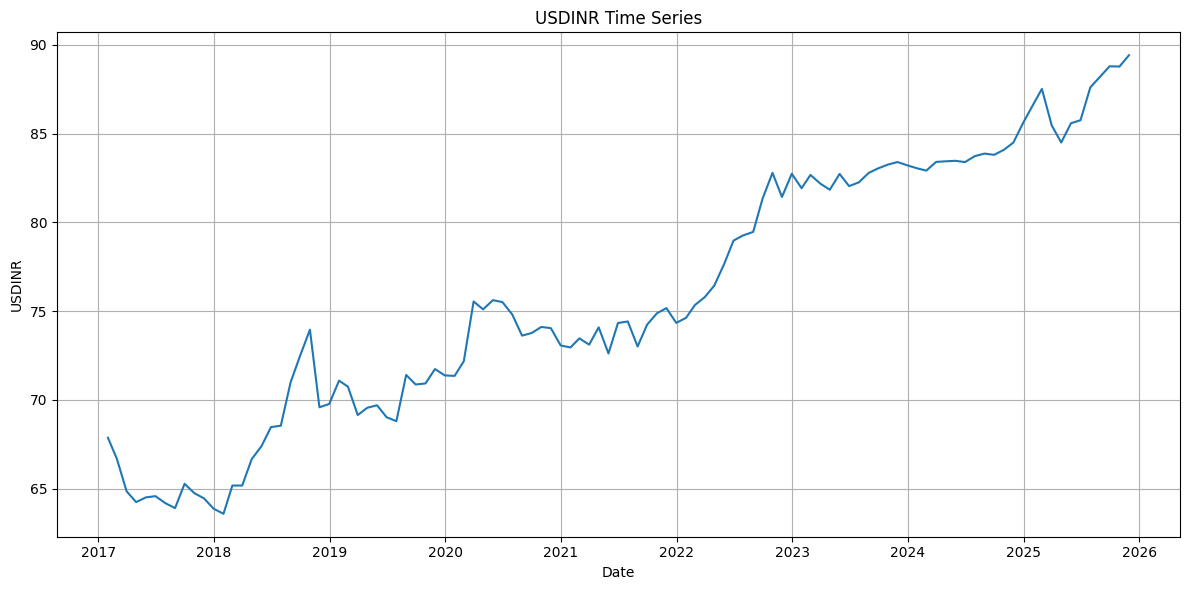

In [16]:
# Check stationarity of USDINR using Augmented Dickey-Fuller test
def check_stationarity(timeseries, title):
    print(f'\n{title}')
    print('='*50)
    
    # Perform Augmented Dickey-Fuller test
    result = adfuller(timeseries.dropna())
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("Result: Time series is stationary (reject null hypothesis)")
    else:
        print("Result: Time series is non-stationary (fail to reject null hypothesis)")
    
    return result[1] <= 0.05

# Check stationarity of USDINR
is_stationary = check_stationarity(df_model['usdinr'], 'Stationarity Test for USDINR')

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df_model.index, df_model['usdinr'])
plt.title('USDINR Time Series')
plt.xlabel('Date')
plt.ylabel('USDINR')
plt.grid(True)
plt.tight_layout()
plt.show()


Stationarity Test for Differenced USDINR
ADF Statistic: -10.593803
p-value: 0.000000
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582
Result: Time series is stationary (reject null hypothesis)



Stationarity Test for Differenced USDINR
ADF Statistic: -10.593803
p-value: 0.000000
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582
Result: Time series is stationary (reject null hypothesis)


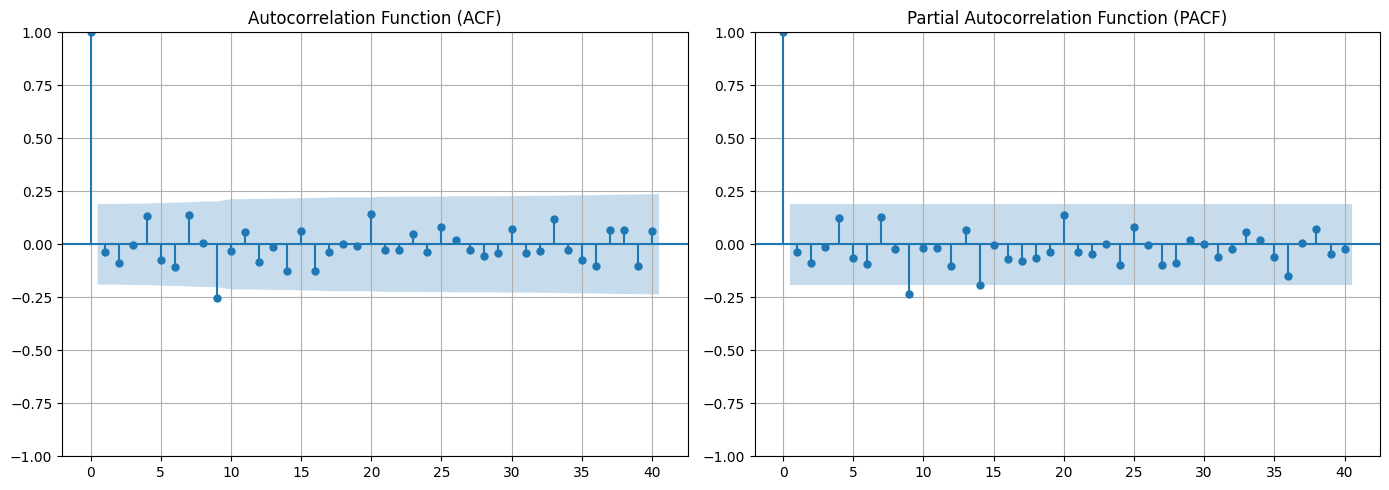

In [17]:
# If not stationary, difference the series
if not is_stationary:
    df_model['usdinr_diff'] = df_model['usdinr'].diff()
    is_stationary_diff = check_stationarity(df_model['usdinr_diff'].dropna(), 'Stationarity Test for Differenced USDINR')
    target_series = df_model['usdinr_diff'].dropna()
else:
    target_series = df_model['usdinr']

# Plot ACF and PACF to determine ARIMA parameters
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(target_series.dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')
axes[0].grid(True)

plot_pacf(target_series.dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [18]:
# Split data into train and test sets (80-20 split)
train_size = int(len(df_model) * 0.8)
train_data = df_model.iloc[:train_size]
test_data = df_model.iloc[train_size:]

print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")
print(f"Training period: {train_data.index[0]} to {train_data.index[-1]}")
print(f"Test period: {test_data.index[0]} to {test_data.index[-1]}")

Training set size: 85
Test set size: 22
Training period: 2017-01-31 00:00:00 to 2024-01-31 00:00:00
Test period: 2024-02-29 00:00:00 to 2025-11-30 00:00:00


In [19]:
# Build ARIMAX model with exogenous variables (now including repo_rate)
# Using the other economic indicators as exogenous variables
exog_vars = ['india_cpi', 'india_unemployment', 'us_cpi', 'us_unemployment', 'rate_differential']

# Prepare training and test exogenous variables
train_exog = train_data[exog_vars]
test_exog = test_data[exog_vars]

# Fit ARIMAX model (trying order (1,1,1) as a starting point)
print("Fitting ARIMAX model with RBI repo rate...")
model = ARIMA(train_data['usdinr'], 
              exog=train_exog,
              order=(1, 1, 1))

model_fit = model.fit()

print("\nModel Summary:")
print(model_fit.summary())

Fitting ARIMAX model with RBI repo rate...

Model Summary:
                               SARIMAX Results                                
Dep. Variable:                 usdinr   No. Observations:                   85
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -124.421
Date:                Mon, 24 Nov 2025   AIC                            264.842
Time:                        20:39:59   BIC                            284.288
Sample:                    01-31-2017   HQIC                           272.659
                         - 01-31-2024                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
india_cpi             -0.0349      0.172     -0.203      0.839      -0.371       0.301
india_unemployment    -0.0732      0.103     -0.

In [20]:
# Make predictions on test set
predictions = model_fit.forecast(steps=len(test_data), exog=test_exog)

# Calculate evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test_data['usdinr'], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data['usdinr'], predictions)
mape = np.mean(np.abs((test_data['usdinr'] - predictions) / test_data['usdinr'])) * 100

print(f"\nModel Performance Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")


Model Performance Metrics:
RMSE: 1.4543
MAE: 1.0080
MAPE: 1.15%


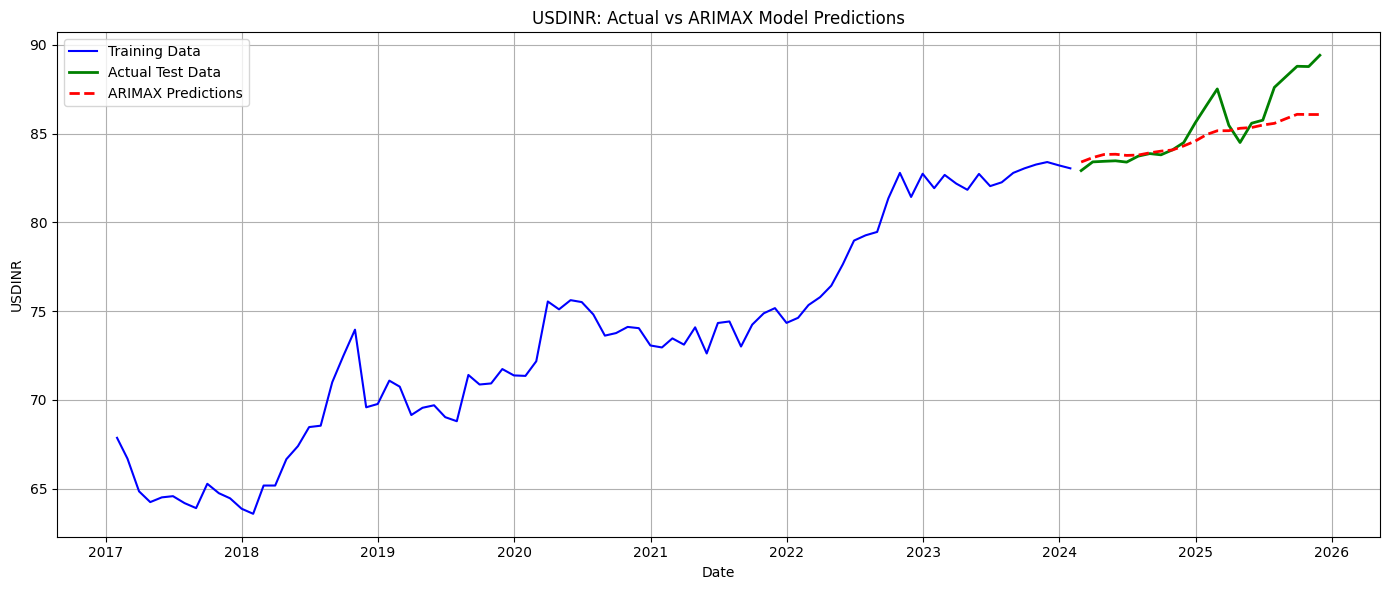

In [21]:
# Plot actual vs predicted values
plt.figure(figsize=(14, 6))

# Plot training data
plt.plot(train_data.index, train_data['usdinr'], label='Training Data', color='blue')

# Plot test data (actual)
plt.plot(test_data.index, test_data['usdinr'], label='Actual Test Data', color='green', linewidth=2)

# Plot predictions
plt.plot(test_data.index, predictions, label='ARIMAX Predictions', color='red', linestyle='--', linewidth=2)

plt.title('USDINR: Actual vs ARIMAX Model Predictions')
plt.xlabel('Date')
plt.ylabel('USDINR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

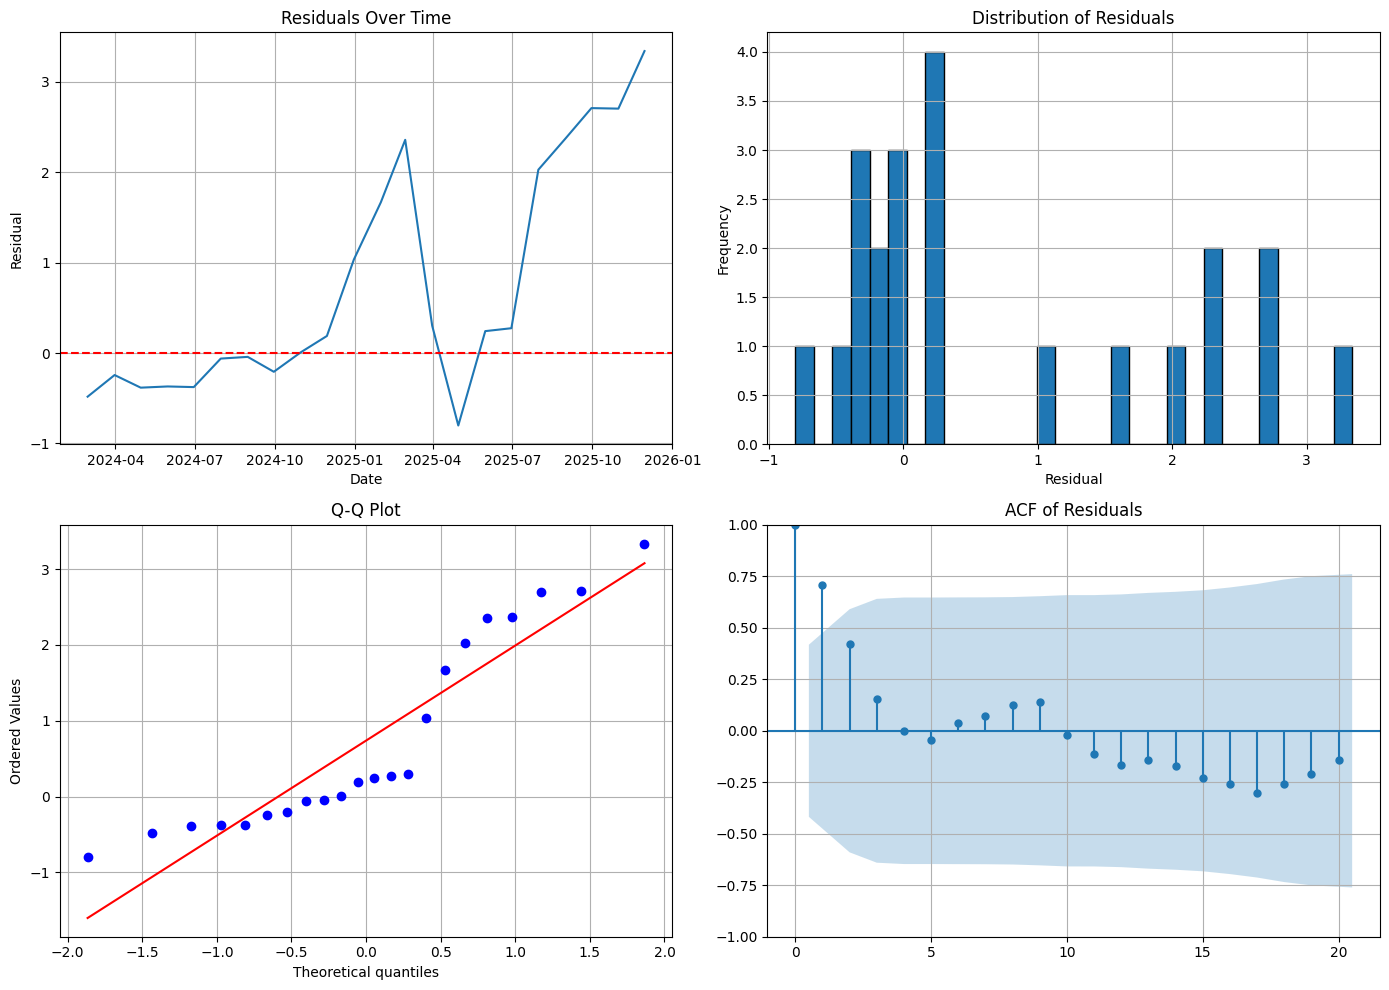

In [22]:
# Plot residuals
residuals = test_data['usdinr'] - predictions

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Residuals over time
axes[0, 0].plot(test_data.index, residuals)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_title('Residuals Over Time')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Residual')
axes[0, 0].grid(True)

# Histogram of residuals
axes[0, 1].hist(residuals, bins=30, edgecolor='black')
axes[0, 1].set_title('Distribution of Residuals')
axes[0, 1].set_xlabel('Residual')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True)

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot')
axes[1, 0].grid(True)

# ACF of residuals
plot_acf(residuals, lags=20, ax=axes[1, 1])
axes[1, 1].set_title('ACF of Residuals')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

Standard deviation of residuals: 1.2826


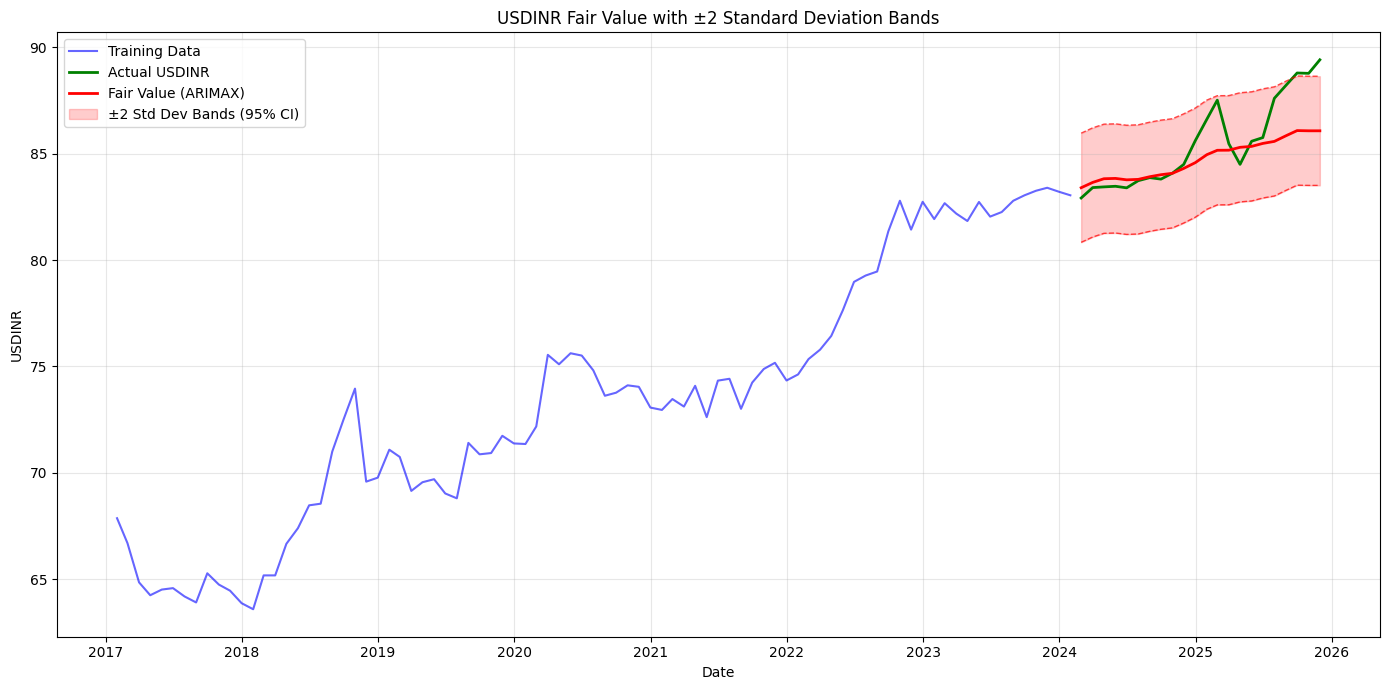


Points outside 2-sigma bands: 3 out of 22 (13.6%)
Expected for normal distribution: ~5%


In [23]:
# Calculate standard deviation of residuals
residual_std = residuals.std()

print(f"Standard deviation of residuals: {residual_std:.4f}")

# Create upper and lower 2-sigma bands
upper_band = predictions + 2 * residual_std
lower_band = predictions - 2 * residual_std

# Plot fair value with 2-sigma bands
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(train_data.index, train_data['usdinr'], label='Training Data', color='blue', alpha=0.6)

# Plot actual test data
plt.plot(test_data.index, test_data['usdinr'], label='Actual USDINR', color='green', linewidth=2)

# Plot fair value (predictions)
plt.plot(test_data.index, predictions, label='Fair Value (ARIMAX)', color='red', linewidth=2)

# Plot 2-sigma bands
plt.fill_between(test_data.index, lower_band, upper_band, 
                 color='red', alpha=0.2, label='±2 Std Dev Bands (95% CI)')
plt.plot(test_data.index, upper_band, color='red', linestyle='--', linewidth=1, alpha=0.7)
plt.plot(test_data.index, lower_band, color='red', linestyle='--', linewidth=1, alpha=0.7)

plt.title('USDINR Fair Value with ±2 Standard Deviation Bands')
plt.xlabel('Date')
plt.ylabel('USDINR')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Check how many actual values fall outside the bands
outside_bands = ((test_data['usdinr'] > upper_band) | (test_data['usdinr'] < lower_band)).sum()
total_points = len(test_data)
pct_outside = (outside_bands / total_points) * 100

print(f"\nPoints outside 2-sigma bands: {outside_bands} out of {total_points} ({pct_outside:.1f}%)")
print(f"Expected for normal distribution: ~5%")